In [7]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [8]:
%store -r df_cleaned

In [9]:
df = df_cleaned 

In [10]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [11]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]
df_train

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26
...,...,...,...,...,...
2024-01-22,2024-04,15.224534,"['25', '24']",A1 & A2 - geschreddert,2024-01-22
2024-01-29,2024-05,14.944941,"['25', '24']",A1 & A2 - geschreddert,2024-01-29
2024-02-05,2024-06,13.757136,"['25', '24']",A1 & A2 - geschreddert,2024-02-05


In [12]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2024-02-26,2024-09,22.155904,"['25', '24']",A1 & A2 - geschreddert,2024-02-26
2024-03-04,2024-10,14.056574,"['25', '24']",A1 & A2 - geschreddert,2024-03-04
2024-03-11,2024-11,5.704197,"['25', '24']",A1 & A2 - geschreddert,2024-03-11
2024-03-18,2024-12,21.771781,"['25', '24']",A1 & A2 - geschreddert,2024-03-18
2024-03-25,2024-13,5.372211,"['25', '24']",A1 & A2 - geschreddert,2024-03-25
2024-04-01,2024-14,-2.297377,"['25', '24']",A1 & A2 - geschreddert,2024-04-01
2024-04-08,2024-15,1.815280,"['25', '24']",A1 & A2 - geschreddert,2024-04-08
2024-04-15,2024-16,5.515964,"['25', '24']",A1 & A2 - geschreddert,2024-04-15
2024-04-22,2024-17,10.971897,"['25', '24']",A1 & A2 - geschreddert,2024-04-22


## Decision Tree

### Walk-forward

In [13]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [14]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)
dt_data = series_to_supervised(X, n_in=4)

In [15]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [16]:
from sklearn.tree import DecisionTreeRegressor


In [17]:
# walk-forward validation for univariate data
def dt_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = decision_tree_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

# return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [18]:
# fit an random forest model and make a one step prediction
def decision_tree_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = DecisionTreeRegressor(random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 #print(yhat)
 return yhat[0]

In [19]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward forecast Accuracy of: wPreis')
wf_accuracy_prod = dt_walk_forward_validation(dt_data, 6)
# for k, v in wf_accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward forecast Accuracy of: wPreis


MAE: 7.835
ME: 1.156
RMSE: 9.811
Direction Accuracy: 0.600


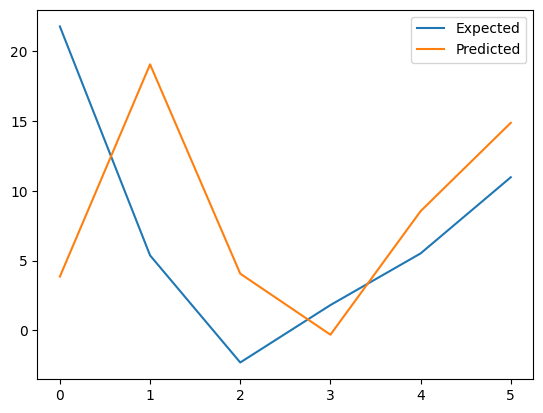

In [20]:
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

# evaluate
# mae, me, rmse, y, yhat, direction_accuracy = dt_walk_forward_validation(dt_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [21]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_wf = pd.DataFrame(results)
DecisionTree_wf

,mae,me,rmse,direction_accuracy
0,7.835223,1.155846,9.811467,0.6


In [22]:
%store DecisionTree_wf


Stored 'DecisionTree_wf' (DataFrame)


### Rolling forecast for Decision Tree

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [23]:
train, test = train_test_split(dt_data, nobs)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]


In [24]:
model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
model_dt_rolling.fit(trainX, trainy)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [25]:
predictions = list()
direction_accuracies = list() 

In [26]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print([testX])
    yhat = model_dt_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[array([14.94494128, 13.7571362 , 17.34321268, 19.08385688])]
>expected=22.2, predicted=23.3
[array([13.7571362 , 17.34321268, 19.08385688, 22.15590367])]
>expected=14.1, predicted=23.3
[array([17.34321268, 19.08385688, 22.15590367, 14.05657364])]
>expected=5.7, predicted=9.5
[array([19.08385688, 22.15590367, 14.05657364,  5.70419682])]
>expected=21.8, predicted=9.5
[array([22.15590367, 14.05657364,  5.70419682, 21.77178067])]
>expected=5.4, predicted=23.3
[array([14.05657364,  5.70419682, 21.77178067,  5.37221127])]
>expected=-2.3, predicted=9.5
[array([ 5.70419682, 21.77178067,  5.37221127, -2.29737704])]
>expected=1.8, predicted=-0.8
[array([21.77178067,  5.37221127, -2.29737704,  1.8152799 ])]
>expected=5.5, predicted=9.5
[array([ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431])]
>expected=11.0, predicted=9.5


MAE: 7.148
ME: 3.527
RMSE: 9.057
Direction Accuracy: 0.375


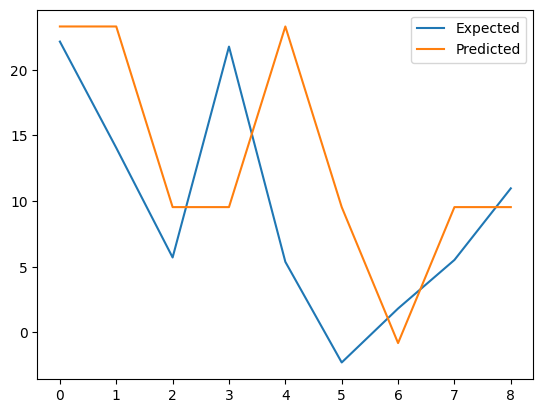

In [27]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [28]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_roll = pd.DataFrame(roll_results)
DecisionTree_roll

,mae,me,rmse,direction_accuracy
0,7.148119,3.527439,9.056628,0.375


In [29]:
%store DecisionTree_roll

Stored 'DecisionTree_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a recursive autoregressive (multi-step) forecaster.

In [30]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [31]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
)

In [32]:
y_train = df_train['wPreis']

# Check if y_train is a pandas Series
# print(isinstance(y_train, pd.Series))  # Should print True

In [33]:
# Now you can pass y_train to forecaster.fit()
forecaster.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [34]:
# Predict the test period
predicted_test = forecaster.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [35]:
predicted_test

4     13.767914
5     17.343213
6     18.168432
7     13.767914
8     17.343213
9     18.168432
10    13.767914
11    17.343213
12    18.168432
Name: pred, dtype: float64

In [36]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast) # MAE
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [37]:
predicted_test.index = df_test.index


Decision Tree Static Forecast Accuracy of: wPreis
mae    :  10.6173
me     :  6.9747
rmse   :  11.5339
direction_accuracy :  0.25


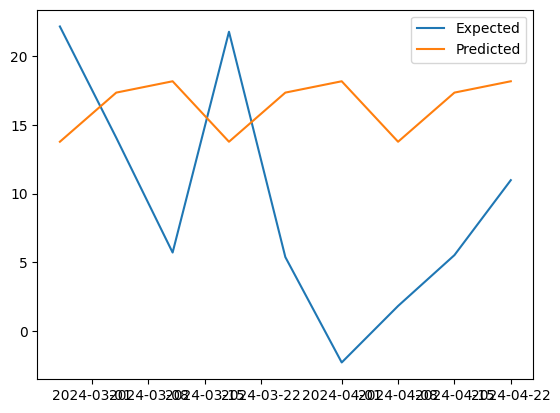

In [38]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Static Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

In [39]:
DecisionTree_static = pd.DataFrame([stat_accuracy_prod])
DecisionTree_static



,mae,me,rmse,direction_accuracy
0,10.617329,6.974694,11.533878,0.25


In [40]:
%store DecisionTree_static

Stored 'DecisionTree_static' (DataFrame)


## All other clusters and categories 

In [41]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    # Define the forecaster
    forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
    )

    y_train = df_train['wPreis']
    forecaster.fit(y=y_train)
    predicted_test = forecaster.predict(steps = len(df_test))
    predicted_test.index = df_test.index

    #print(f'Decision Tree Static Forecast Accuracy of: wPreis in {cluster} for {category}')
    return forecast_accuracy(predicted_test, df_test['wPreis'])
    # for k, v in stat_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))






In [42]:
def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(dt_data, nobs)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
    model_dt_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print([testX])
        yhat = model_dt_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat[0])
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': overall_direction_accuracy}

    # print(f'Decision Tree Rolling forecast Accuracy of: wPreis in {cluster} for {category}')
    # print('MAE: %.3f' % mae)
    # print('ME: %.3f' % me)
    # print('RMSE: %.3f' % rmse)
    # print('Direction Accuracy: %.3f' % overall_direction_accuracy)

In [43]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    # print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = dt_walk_forward_validation(dt_data, nobs)
    return wf_accuracy_prod
    # mae = wf_accuracy_prod['mae']
    # me = wf_accuracy_prod['me']
    # rmse = wf_accuracy_prod['rmse']
    # expected = wf_accuracy_prod['expected']
    # predictions = wf_accuracy_prod['predictions']
    # direction_accuracy = wf_accuracy_prod['direction_accuracy']
    # print('MAE: %.3f' % mae)
    # print('ME: %.3f' % me)
    # print('RMSE: %.3f' % rmse)
    # print('Direction Accuracy: %.3f' % direction_accuracy)


In [44]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [45]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')

In [46]:
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    rolling_results = rolling_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'DecisionTree_static_mae': static_results['mae'],
        'DecisionTree_static_me': static_results['me'],
        'DecisionTree_static_rmse': static_results['rmse'],
        'DecisionTree_static_direction_accuracy': static_results['direction_accuracy'],
        'DecisionTree_rolling_mae': rolling_results['mae'],
        'DecisionTree_rolling_me': rolling_results['me'],
        'DecisionTree_rolling_rmse': rolling_results['rmse'],
        'DecisionTree_rolling_direction_accuracy': rolling_results['direction_accuracy'],
        'DecisionTree_wf_mae': wf_results['mae'],
        'DecisionTree_wf_me': wf_results['me'],
        'DecisionTree_wf_rmse': wf_results['rmse'],
        'DecisionTree_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
# df_results


In [47]:
df_results.to_csv('DecisionTree_Results.csv')

In [48]:
df_metrics = df_results[['Cluster', 'Category', 'DecisionTree_static_rmse', 'DecisionTree_rolling_rmse',  'DecisionTree_wf_rmse', 'DecisionTree_static_direction_accuracy', 'DecisionTree_rolling_direction_accuracy', 'DecisionTree_wf_direction_accuracy']]

In [49]:
def getRMSEplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_rmse = df_plot['DecisionTree_static_rmse']
    rolling_rmse = df_plot['DecisionTree_rolling_rmse']
    wf_rmse = df_plot['DecisionTree_wf_rmse']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_rmse, bar_width, label='Static RMSE')
    ax.barh([x + bar_width for x in ind], rolling_rmse, bar_width, label='Rolling RMSE')
    ax.barh([x + 2*bar_width for x in ind], wf_rmse, bar_width, label='Walk-forward RMSE')

    # Add RMSE values next to each bar
    for i, (s_rmse, r_rmse, wf_rmse) in enumerate(zip(static_rmse, rolling_rmse, wf_rmse)):
        ax.text(s_rmse, i, f'{s_rmse:.2f}', ha='right', va='center')
        ax.text(r_rmse, i + bar_width, f'{r_rmse:.2f}', ha='right', va='center')
        ax.text(wf_rmse, i + 2*bar_width, f'{wf_rmse:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Comparison of Decision Tree RMSE for Static, Rolling, and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Add legend
    ax.legend()

    # Show plot
    plt.show()


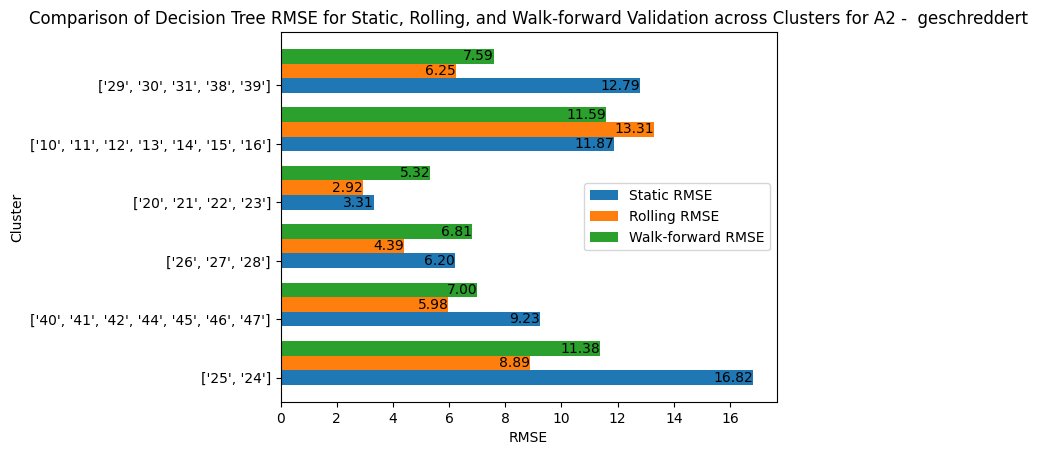

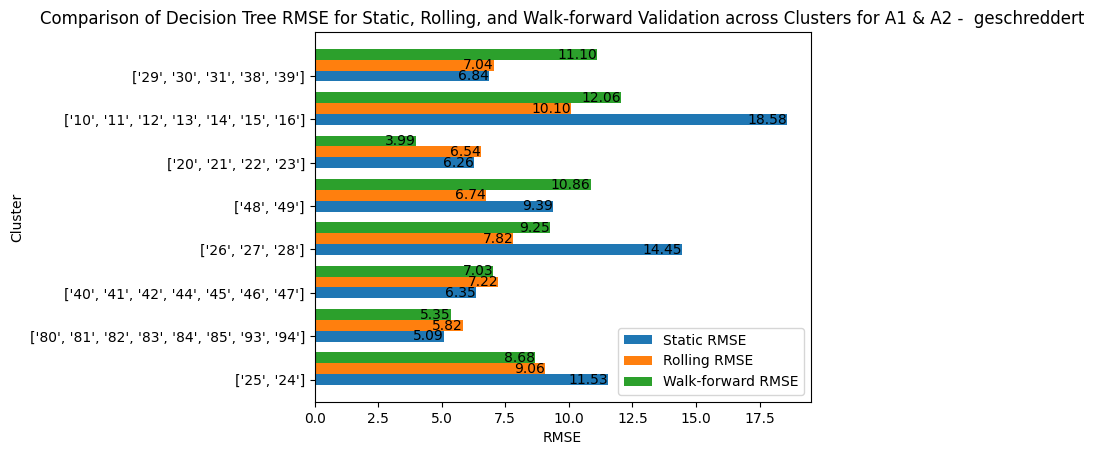

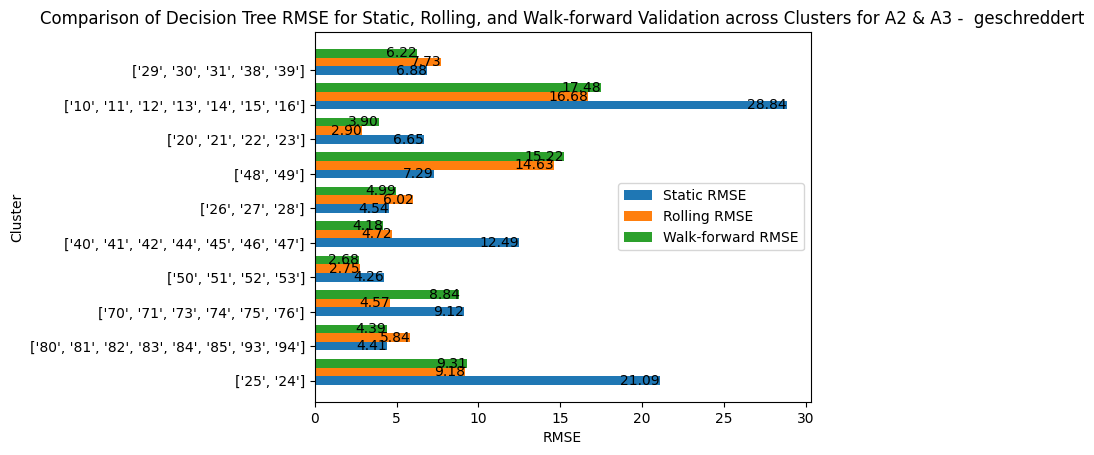

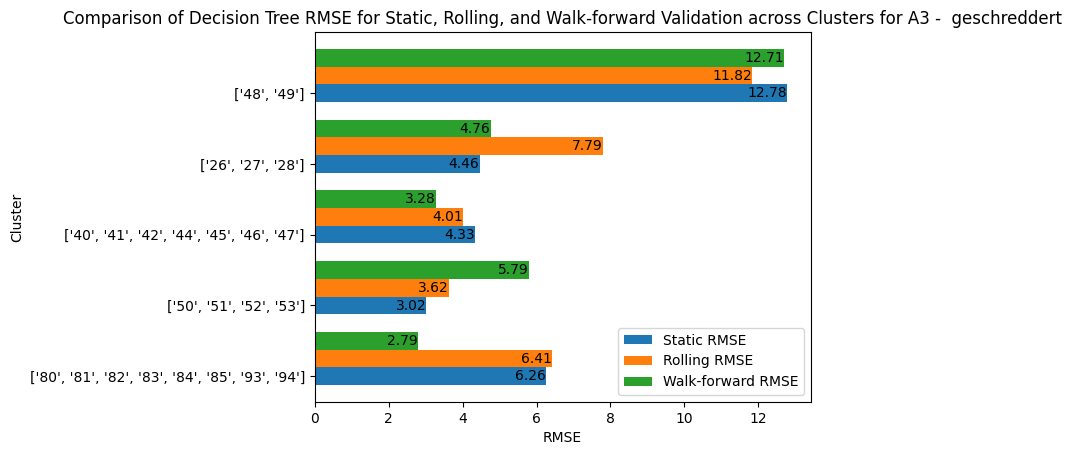

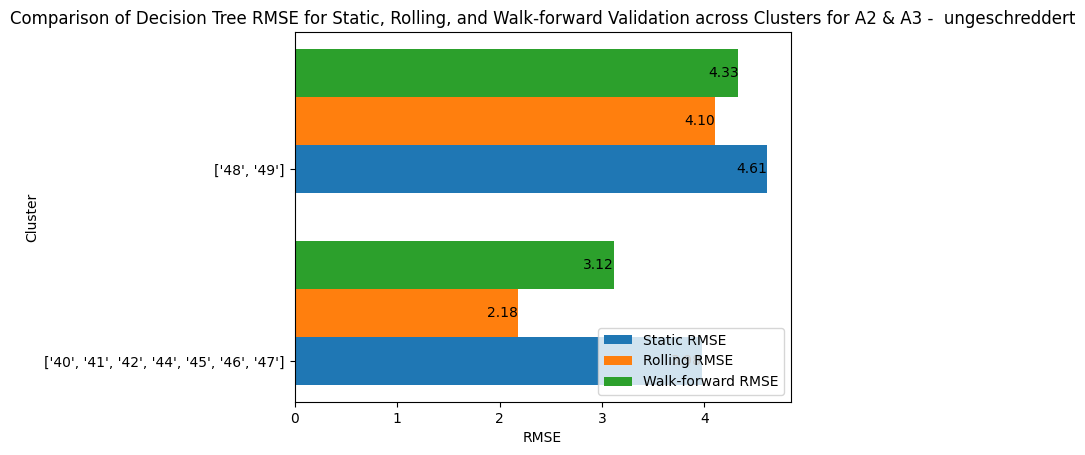

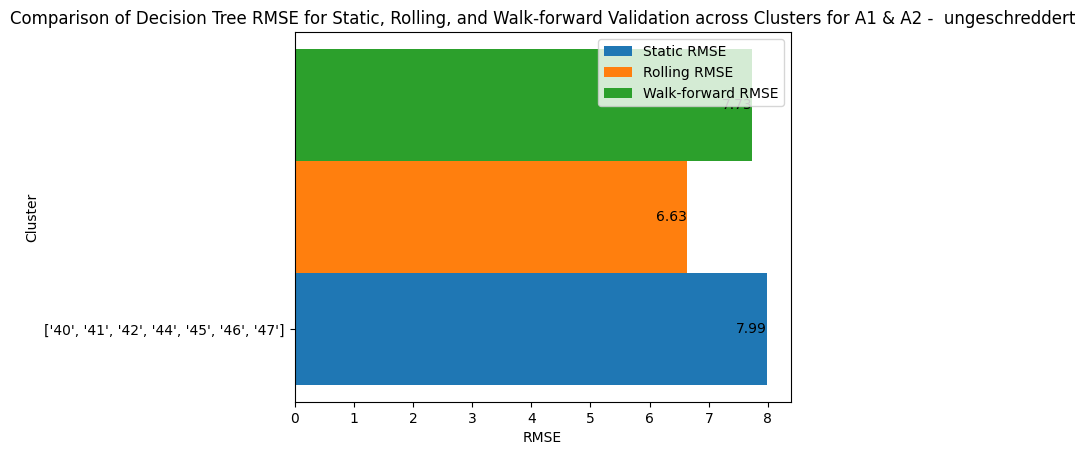

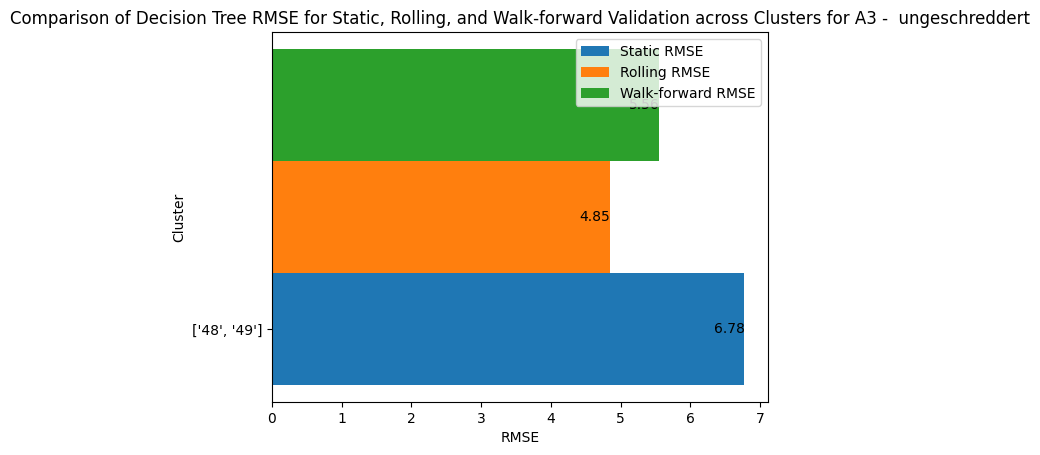

In [50]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)

In [51]:
def getDirAccplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_dir_acc = df_plot['DecisionTree_static_direction_accuracy']
    rolling_dir_acc = df_plot['DecisionTree_rolling_direction_accuracy']
    wf_dir_acc = df_plot['DecisionTree_wf_direction_accuracy']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_dir_acc, bar_width, label='Static Direction Accuracy')
    ax.barh([x + bar_width for x in ind], rolling_dir_acc, bar_width, label='Rolling Direction Accuracy')
    ax.barh([x + 2*bar_width for x in ind], wf_dir_acc, bar_width, label='Walk-forward Direction Accuracy')

    # Add Direction Accuracy values next to each bar
    for i, (s_dir_acc, r_dir_acc, wf_dir_acc) in enumerate(zip(static_dir_acc, rolling_dir_acc, wf_dir_acc)):
        ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
        ax.text(r_dir_acc, i + bar_width, f'{r_dir_acc:.2f}', ha='right', va='center')
        ax.text(wf_dir_acc, i + 2*bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('Direction Accuracy')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Comparison of Direction Accuracy using Decision Trees between Static, Rolling, and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}')

    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

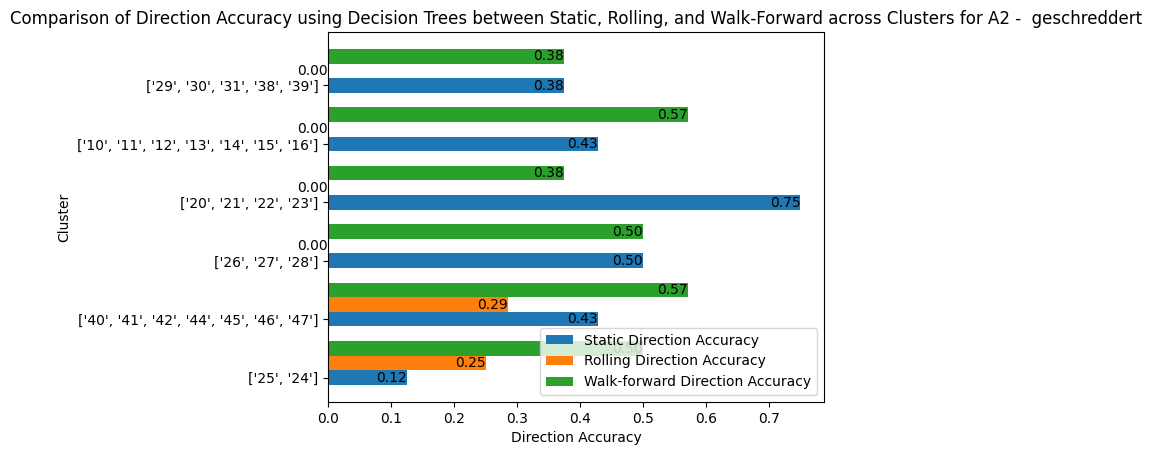

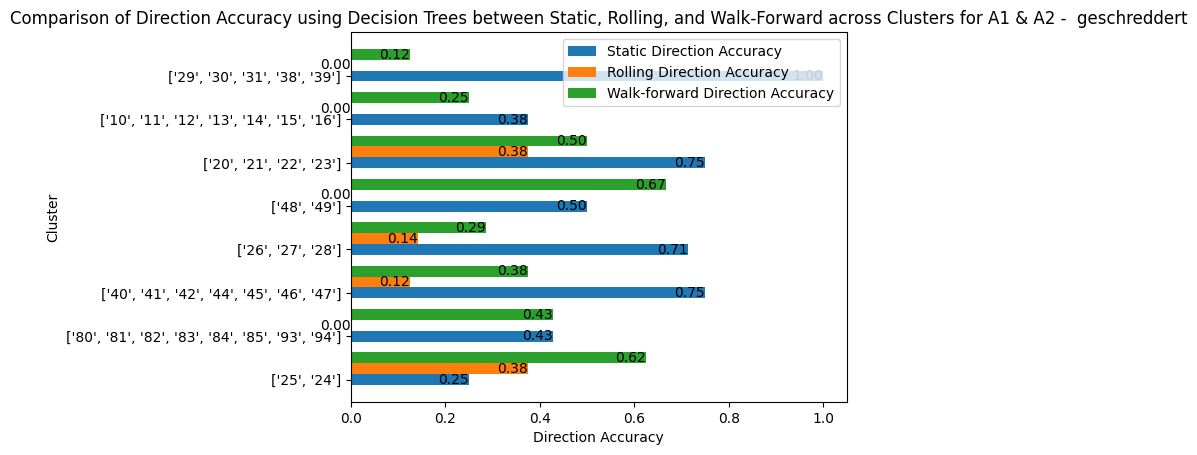

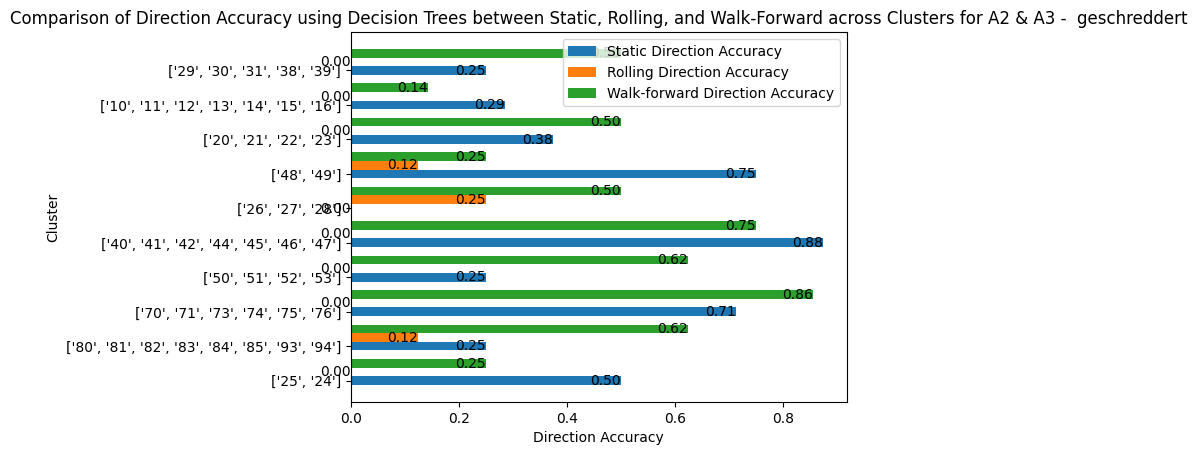

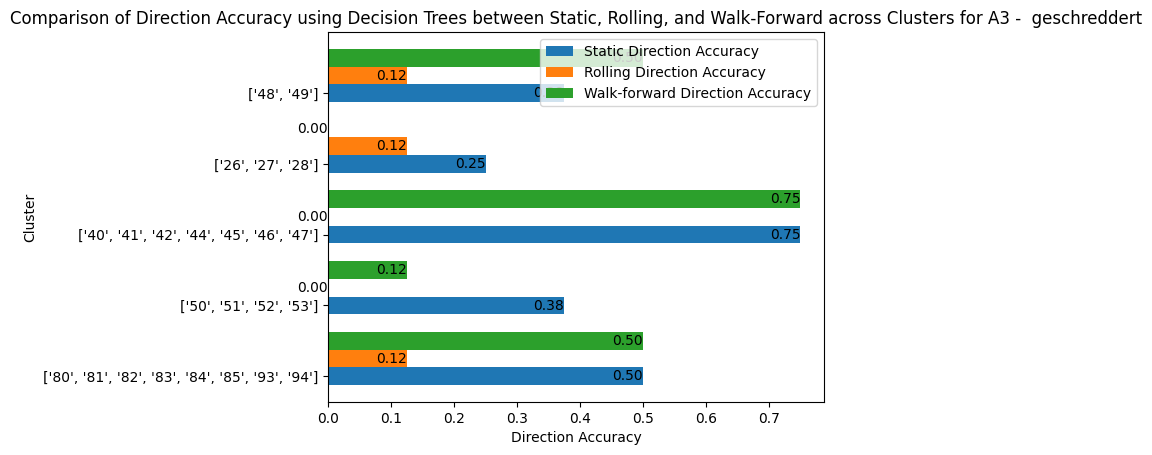

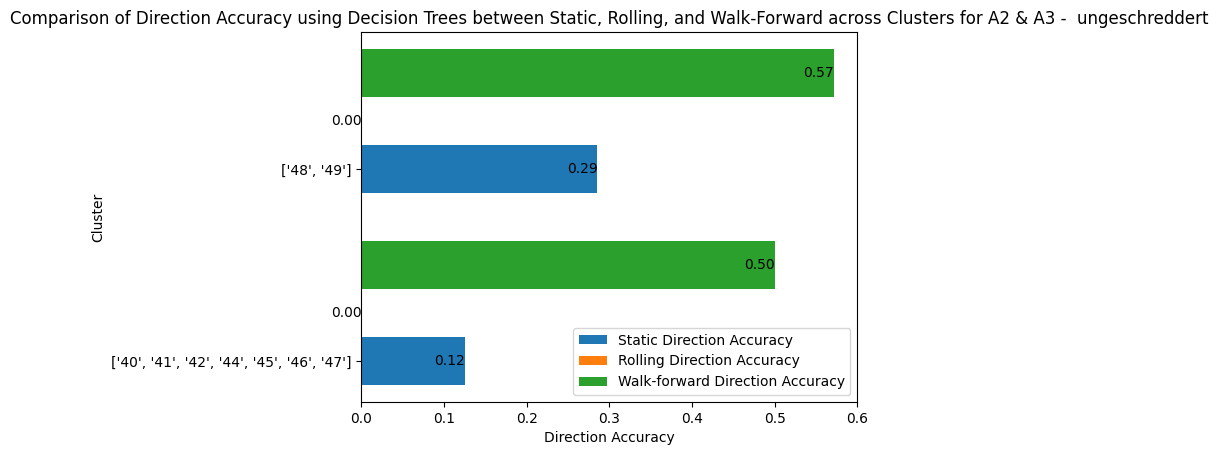

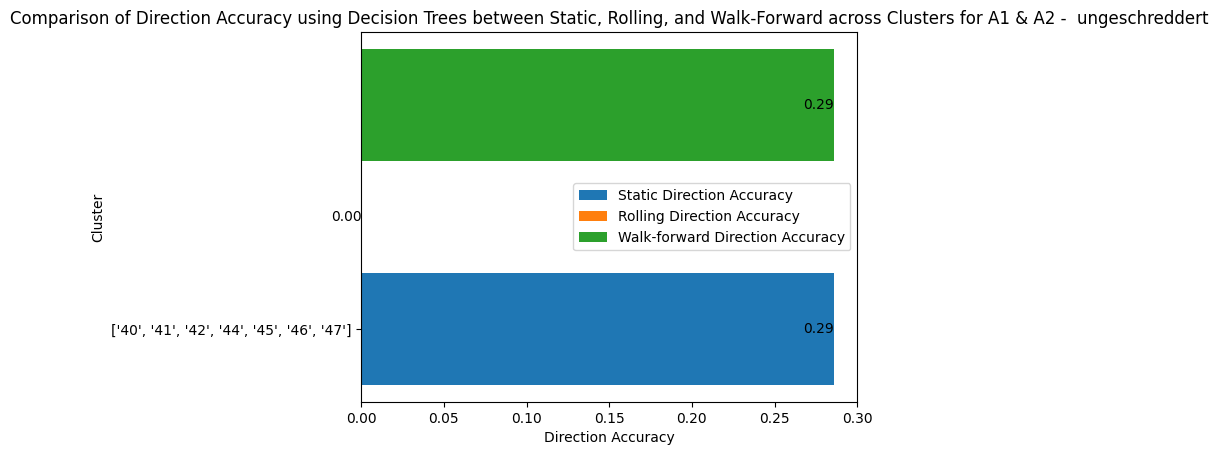

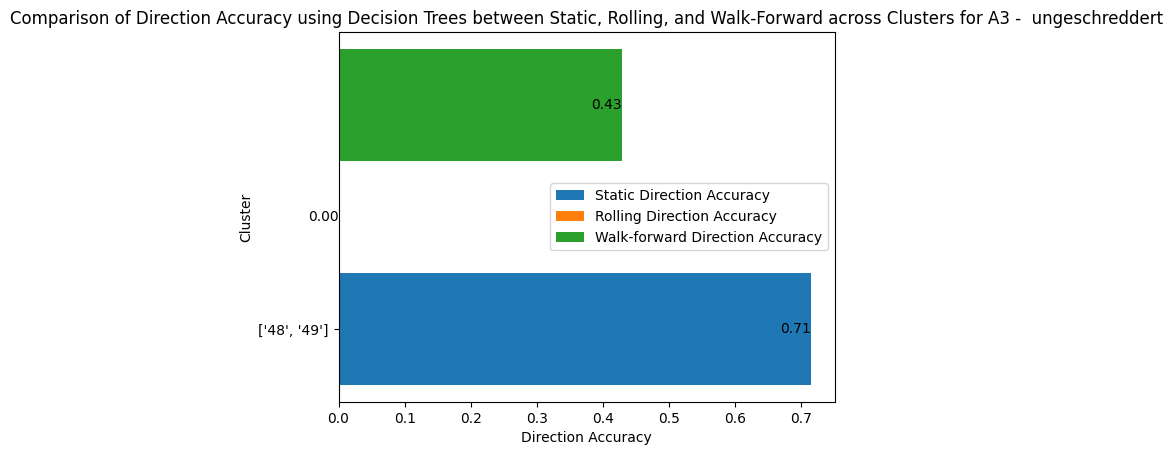

In [52]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getDirAccplot(filtered)

PLOTLY GRAPHS FOR THE SAME

In [213]:
def getRMSEplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['DecisionTree_static_rmse', 'DecisionTree_rolling_rmse',  'DecisionTree_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Decision Tree RMSE for Static, Rolling and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [214]:
def getDirAccplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['DecisionTree_static_direction_accuracy', 'DecisionTree_rolling_direction_accuracy', 'DecisionTree_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy using Decision Trees between Static, Rolling and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [215]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)